In [34]:
# Import necessary libraries
from src.models import LSTModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from os.path import dirname, join as pjoin
import torch
from torch import nn
import scipy.signal as signal


# Set data type and device
dtype = torch.float
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cpu")

# Close all open plots
plt.close('all')

In [35]:
# Load data from file
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output.mat')
data_out = scipy.io.loadmat(filepath)

# Extract data from dictionary
dExp, yExp, dExp_val, yExp_val, time__ = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__']
nExp = yExp.size


In [36]:
# Create time vector
#t = np.arange(0, np.size(dExp[0, 0], 1) * Ts, Ts)
t = time__

# Set end time
t_end = t.size

# Initialize input and output tensors
u = torch.zeros(nExp, t_end, 5)
y = torch.zeros(nExp, t_end, 2)

# Set input number
inputnumberD = 4

# Fill input and output tensors with data
for j in range(nExp):
    #inputActive = (torch.from_numpy(dExp[0, j]))
    u[j, :, :] = (torch.from_numpy(dExp[0, j]))
    y[j, :, :] = (torch.from_numpy(yExp[0, j]))
    u[j, :, 4] = torch.from_numpy(signal.medfilt((u[j, :, 4]).numpy(), 15))

# Set random seed for reproducibility
seed = 1
torch.manual_seed(seed)

In [37]:
#Set dimensions for RNN layers
idd = dExp[0, 0].shape[1]
hdd = 10 #7 /10
ldd = 2 #2
odd = yExp[0, 0].shape[1]

# Initialize RNN model
LTS = LSTModel(idd, hdd, ldd, odd)

# Define loss function
MSE = nn.MSELoss()

# Define optimization method
learning_rate = 1.0e-2
optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Set number of epochs
epochs = 400

# Initialize array to store loss values
LOSS = np.zeros(epochs)


In [38]:
# Train the RNN model
for epoch in range(epochs):
    # Adjust learning rate at certain epochs
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0

    # Get RNN output for training data
    yLTS = LTS(u)
    yLTS = torch.squeeze(yLTS)
    

    # Calculate loss and backpropagate
    loss = MSE(yLTS, y)
    loss.backward()
    optimizer.step()
    

    # Print loss for current epoch
    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    LOSS[epoch] = loss

Epoch: 1 	||	 Loss: 0.2960876524448395
Epoch: 2 	||	 Loss: 0.23402506113052368
Epoch: 3 	||	 Loss: 0.17774878442287445
Epoch: 4 	||	 Loss: 0.12320761382579803
Epoch: 5 	||	 Loss: 0.07134020328521729
Epoch: 6 	||	 Loss: 0.029840387403964996
Epoch: 7 	||	 Loss: 0.011953260749578476
Epoch: 8 	||	 Loss: 0.01976523920893669
Epoch: 9 	||	 Loss: 0.03124147094786167
Epoch: 10 	||	 Loss: 0.033203039318323135
Epoch: 11 	||	 Loss: 0.02724500186741352
Epoch: 12 	||	 Loss: 0.01902439445257187
Epoch: 13 	||	 Loss: 0.012838564813137054
Epoch: 14 	||	 Loss: 0.01017705351114273
Epoch: 15 	||	 Loss: 0.01032639667391777
Epoch: 16 	||	 Loss: 0.011729449033737183
Epoch: 17 	||	 Loss: 0.013056636787950993
Epoch: 18 	||	 Loss: 0.013594956137239933
Epoch: 19 	||	 Loss: 0.013179062865674496
Epoch: 20 	||	 Loss: 0.011981693096458912
Epoch: 21 	||	 Loss: 0.010330748744308949
Epoch: 22 	||	 Loss: 0.008587677031755447
Epoch: 23 	||	 Loss: 0.007071244064718485
Epoch: 24 	||	 Loss: 0.006008448079228401
Epoch: 25 	||

In [32]:
# Initialize input and output tensors for validation data
nExp = yExp_val.size
uval = torch.zeros(nExp, t_end, 5)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    inputActive = (torch.from_numpy(dExp_val[0, j]))
    uval[j, :, :] = torch.unsqueeze(inputActive[:,inputnumberD], 1)
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))
    uval[j, :, 4] = torch.from_numpy(signal.medfilt((uval[j, :, 4]).numpy(), 15))

# Get RNN output for validation data
yLTS_val = LTS(uval)
#yLTS_val = yLTS_val.unsqueeze_(0)

# Calculate loss for validation data
loss_val = MSE(yLTS_val, yval)

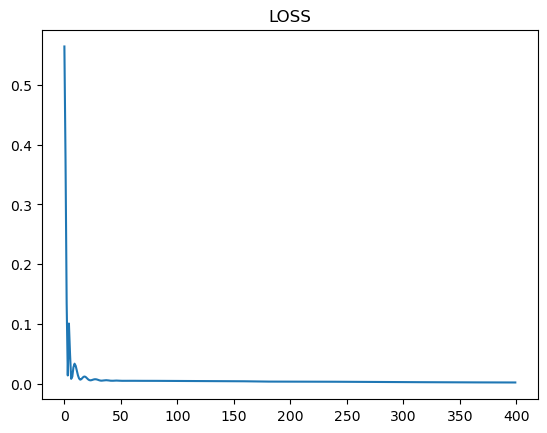

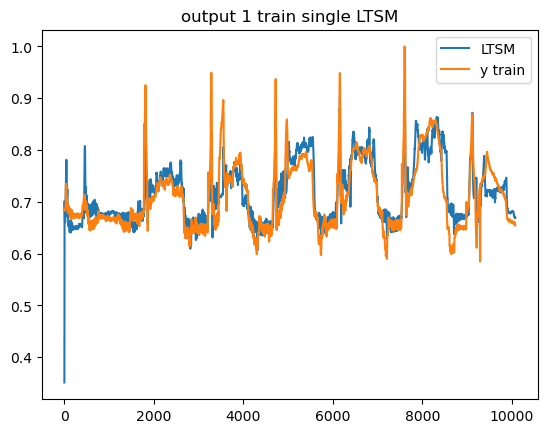

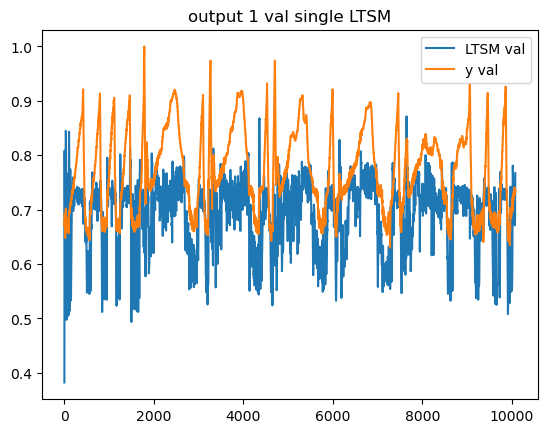

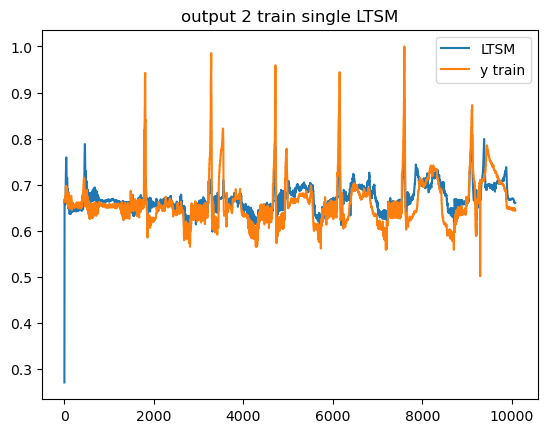

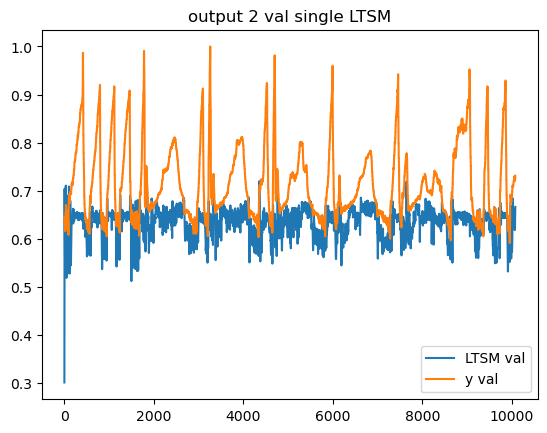

Loss Validation single LTSM: 0.01085665076971054


In [33]:
# Plot loss over epochs
plt.figure('8')
plt.plot(LOSS)
plt.title("LOSS")
plt.show()

# Plot output 1 for training data
plt.figure('9')
plt.plot(yLTS[0, :, 0].detach().numpy(), label='LTSM')
plt.plot(y[0, :, 0].detach().numpy(), label='y train')
plt.title("output 1 train single LTSM")
plt.legend()
plt.show()

# Plot output 1 for validation data
plt.figure('10')
plt.plot(yLTS_val[0, :, 0].detach().numpy(), label='LTSM val')
plt.plot(yval[0, :, 0].detach().numpy(), label='y val')
plt.title("output 1 val single LTSM")
plt.legend()
plt.show()

# Plot output 2 for training data
plt.figure('11')
plt.plot(yLTS[0, :, 1].detach().numpy(), label='LTSM')
plt.plot(y[0, :, 1].detach().numpy(), label='y train')
plt.title("output 2 train single LTSM")
plt.legend()
plt.show()

# Plot output 2 for validation data
plt.figure('12')
plt.plot(yLTS_val[0, :, 1].detach().numpy(), label='LTSM val')
plt.plot(yval[0, :, 1].detach().numpy(), label='y val')
plt.title("output 2 val single LTSM")
plt.legend()
plt.show()

# Save RNN output and validation data to file
scipy.io.savemat('data_singleRNN_sysID_LTSM.mat', dict(yLTSm_val=yLTS_val.detach().numpy(), yval=yval.detach().numpy()))

# Print validation loss
print(f"Loss Validation single LTSM: {loss_val}")